<a href="https://colab.research.google.com/github/HarshalPawar88/Book-Recommendation-System/blob/main/Final_Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**


---


### During the last few decades, recommender systems have taken more and more place in our lives. From e-commerce to online advertisement, recommender systems are today unavoidable in our daily online journeys.

### In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users. Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

# **Data Description**


---



## **The Book-Crossing dataset comprises 3 files.**

##**● Users**

###Contains the users. Note that user IDs (User-ID) have been anonymized and map to
###integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

##**● Books**

###Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title,Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S,Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

##**● Ratings**
###Contains the book rating information. Ratings (Book-Rating) are either explicit,
###expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.

In [1]:
#importig the necessary libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import math
import random
import sklearn
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import words
from nltk.stem import WordNetLemmatizer



In [2]:
#importing all the three dataframes that we had
df_books=pd.read_csv('books.csv')
df_ratings=pd.read_csv('Ratings.csv')
df_user=pd.read_csv('users.csv')

/var/folders/4m/ykffh7vn0mjdcbcw9mrnzvt80000gn/T/ipykernel_52492/1340344022.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books=pd.read_csv('books.csv')


#**1. Primary Inspection**

### A) Removing the Duplicates in the Books Data Frame Before Mergeing

In [3]:
#filling the missing values with 'Unknown'
df_books['Book-Author'].fillna('Unknown',inplace=True)

In [4]:
# Define a function to combine to columns namely title and author
def change_title(str1,str2):
  '''Change the title of books'''
  str1 = str1 +" "+'by' +" "+str2
  return str1

In [5]:
#shape of the dataframe before removing the duplicates
df_books.shape

(271360, 8)

In [6]:
# Create a new column for title
df_books['new_title'] = df_books.apply(lambda x : change_title(x['Book-Title'],x['Book-Author']),axis = 1)

In [7]:
# Get rid of duplications
df_books = df_books.drop_duplicates(subset='new_title',keep='first')

In [8]:
#shape of the dataframe after removing the duplicates
df_books.shape

(251185, 9)

In [9]:
271360-251185

20175

We can see that there were 20175 duplicates in books dataframe.

In [10]:
# defining print as p
p=print

In [11]:
#merging all the three dataset
df_merged = df_ratings.merge(df_books,how='inner',on='ISBN')
df_merged = df_merged.merge(df_user,how='inner',on='User-ID')


In [12]:
df_merged.shape

(916933, 13)

In [13]:
#adding a new column that measures the length of the title
df_merged['Title-Length'] = df_merged['Book-Title'].apply(len)
df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'], errors='coerce').fillna(2099, downcast = 'infer')

/var/folders/4m/ykffh7vn0mjdcbcw9mrnzvt80000gn/T/ipykernel_52492/3072709777.py:3: FutureWarning: The 'downcast' keyword in fillna is deprecated and will be removed in a future version. Use res.infer_objects(copy=False) to infer non-object dtype, or pd.to_numeric with the 'downcast' keyword to downcast numeric results.
  df_merged['Year-Of-Publication'] = pd.to_numeric(df_merged['Year-Of-Publication'], errors='coerce').fillna(2099, downcast = 'infer')


In [14]:
#description of the features
df_merged.describe(include='all')

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Length
count,916933.00000,916933,916933.000000,916933,916933,916933.000000,916931,916933,916933,916929,916933,916933,671659.000000,916933.000000
unique,NaN,250075,NaN,241061,101586,NaN,16542,250074,250074,250071,250075,21418,NaN,NaN
top,NaN,0971880107,NaN,Wild Animus,Nora Roberts,NaN,Ballantine Books,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,http://images.amazon.com/images/P/0971880107.0...,Wild Animus by Rich Shapero,"toronto, ontario, canada",NaN,NaN
freq,NaN,2502,NaN,2502,7645,NaN,30011,2502,2502,2502,2502,13115,NaN,NaN
mean,140202.83165,NaN,2.825417,NaN,NaN,1968.353922,NaN,NaN,NaN,NaN,NaN,NaN,37.340037,34.243288
std,80804.41894,NaN,3.848183,NaN,NaN,230.251189,NaN,NaN,NaN,NaN,NaN,NaN,14.073900,23.618870
min,2.00000,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000
25%,69697.00000,NaN,0.000000,NaN,NaN,1991.000000,NaN,NaN,NaN,NaN,NaN,NaN,28.000000,16.000000
50%,140410.00000,NaN,0.000000,NaN,NaN,1997.000000,NaN,NaN,NaN,NaN,NaN,NaN,35.000000,28.000000
75%,211426.00000,NaN,7.000000,NaN,NaN,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,45.000000,48.000000


In [15]:
#information of the features
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916933 entries, 0 to 916932
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   User-ID              916933 non-null  int64  
 1   ISBN                 916933 non-null  object 
 2   Book-Rating          916933 non-null  int64  
 3   Book-Title           916933 non-null  object 
 4   Book-Author          916933 non-null  object 
 5   Year-Of-Publication  916933 non-null  int64  
 6   Publisher            916931 non-null  object 
 7   Image-URL-S          916933 non-null  object 
 8   Image-URL-M          916933 non-null  object 
 9   Image-URL-L          916929 non-null  object 
 10  new_title            916933 non-null  object 
 11  Location             916933 non-null  object 
 12  Age                  671659 non-null  float64
 13  Title-Length         916933 non-null  int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 97.9+ MB


In [16]:
916933-671659

245274

### There are 245274 missing values in the age column.

In [17]:
df_merged.loc[df_merged['ISBN'].str.endswith('X')].head(3)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,new_title,Location,Age,Title-Length
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"tyler, texas, usa",NaN,20
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,Flesh Tones: A Novel by M. J. Rose,"cincinnati, ohio, usa",23.0,20
30,2313,080901548X,0,The Dark Child : The Autobiography of an Afric...,Camara Laye,1954,"Farrar, Straus and Giroux",http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,http://images.amazon.com/images/P/080901548X.0...,The Dark Child : The Autobiography of an Afric...,"cincinnati, ohio, usa",23.0,52


## **Conclusion**: Some titles have same ISBN.

## B) Unique Book Titles

In [18]:
len(df_merged['Book-Title'].unique())

241061

## C) Unique ISBNs

In [19]:
len(df_merged['ISBN'].unique())

250075

## D) Unique Users


In [20]:
len(df_merged['User-ID'].unique())

85504

## E) Publication Years

In [21]:
df_merged['Year-Of-Publication'].unique()

array([2002, 1994, 1996, 1998, 2001, 1987, 1984, 1997, 1970, 1978, 1993,
       1989, 1995, 1990, 1992, 1950, 1991, 1999, 1954, 1988, 2003, 2004,
       2000, 1983, 1985, 1982, 1956, 1979, 1986, 1975,    0, 1976, 1977,
       1980, 1981, 1974, 1957, 1958, 1960, 1963, 1969, 1972, 1961, 1971,
       1953, 1968, 1973, 1967, 1962, 1937, 1959, 1955, 2005, 1945, 1965,
       1964, 1927, 2020, 2050, 1920, 1966, 1952, 1930, 1940, 1942, 1947,
       1925, 1923, 2030, 1951, 1936, 1946, 1943, 2099, 1928, 1941, 2011,
       1948, 1901, 1932, 1939, 1944, 1938, 1902, 1929, 1900, 1911, 1949,
       1926, 1933, 1922, 1897, 2026, 1906, 1806, 1935, 2006, 2037, 1921,
       2024, 2038, 1924, 1378, 2008, 1934, 1909, 1931, 1904, 1917, 2012,
       1914, 1376, 1908, 1919])

## **Observation:-** We can clearly see that their are some noise values in the Year of Publication features :-
### 1. **String Noise Values -** such as 'DK Publishing Inc' and 'Gallimard.
### 2. **Integer Noise Values -** Since this data was collected in august 2004, so any year value greater than 2004 is a noise value.

In [22]:
len(df_merged['Publisher'].unique())

16543

# **2. Preprocessing and Feature Engineering**

## 1. Location

In [23]:
# defining a function to extarct the country names
def get_country(x):
  return x.split(',')[-1]
  


In [24]:
#applying the function the location column
df_location = df_user.copy(deep=True)
df_location['country'] = df_user['Location'].apply(get_country)

In [25]:
df_merged['Location'] = df_merged['Location'].apply(get_country)

Extracted just the country names from the location column.

## 2. Age

### a) Creating bins for the age column.

In [26]:
# Create age groups using age column
bins = [-1,12,20,50,100]
labels = ['Kid','Teenager','Adult','Old']
df_merged['age_bins'] = pd.cut(x=df_merged['Age'], bins=bins,labels=labels)

### Labelled 'Kid' for values between between 1-12
### 'Teenager' for values between 13-19
### 'Adult' for values between 20-50
### 'Old' for values greater than 50

### b) Capping Outlier



In [27]:
# Number of outliers
outliers = sum(df_merged['Age']>90)
print(outliers)

2872


/var/folders/4m/ykffh7vn0mjdcbcw9mrnzvt80000gn/T/ipykernel_52492/119048438.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_merged['Age'].dropna())
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conv

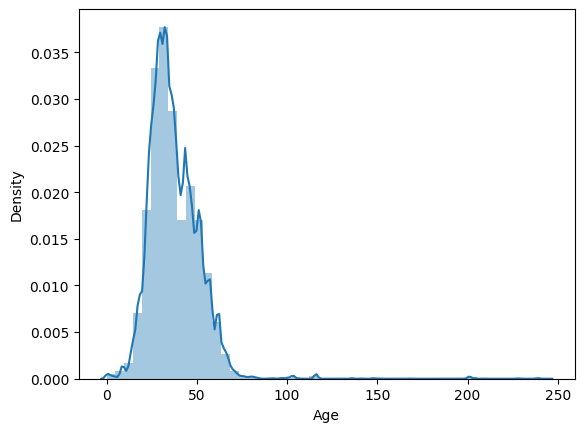

In [28]:
# Plot Distribution of Age
sns.distplot(df_merged['Age'].dropna())
# Handling outliers by randomly replacing age >90 by values between 90 and 100
age2 = df_merged['Age'].copy()
random_age2 = np.random.randint(90,100,outliers)
age2[df_merged['Age']>90]=random_age2
df_merged['Age'] = age2

##3.Handling Missing Value

In [29]:
# Missing Value Count Function
def show_missing(y):
    missing = y.columns[y.isnull().any()].tolist()
    return missing

def print_missing(x):
  # Missing data counts and percentage
  print('Missing Data Count')
  print(x[show_missing(x)].isnull().sum().sort_values(ascending = False))
  print('--'*50)
  print('Missing Data Percentage')
  print(round(x[show_missing(x)].isnull().sum().sort_values(ascending = False)/len(x)*100,2))

### Missing values for different features

In [30]:
print_missing(df_user)

Missing Data Count
Age    110762
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Age    39.72
dtype: float64


In [31]:
print_missing(df_books)

Missing Data Count
Image-URL-L    3
Publisher      2
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Image-URL-L    0.0
Publisher      0.0
dtype: float64


In [32]:
print_missing(df_ratings)

Missing Data Count
Series([], dtype: float64)
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Series([], dtype: float64)


In [33]:
print_missing(df_location)

Missing Data Count
Age    110762
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
Age    39.72
dtype: float64


In [34]:
print_missing(df_merged)

Missing Data Count
age_bins       247826
Age            245274
Image-URL-L         4
Publisher           2
dtype: int64
----------------------------------------------------------------------------------------------------
Missing Data Percentage
age_bins       27.03
Age            26.75
Image-URL-L     0.00
Publisher       0.00
dtype: float64


###a) Dealing with the missing values of age.

In [35]:
# Null values in age column
nulls = sum(df_merged['Age'].isnull())
print('Null values in Age: ',nulls)

Null values in Age:  245274


In [36]:
# Replacing null values
median = df_merged['Age'].median()
std = df_merged['Age'].std()
random_age = np.random.randint(median - std, median + std, size = nulls)
age = df_merged['Age'].copy()
age[pd.isnull(age)] = random_age
df_merged['Age'] = age
df_merged['Age'] = df_merged['Age'].astype(int)

In [37]:
df_merged.shape

(916933, 15)

## 4. Calculating the Rating Count and Rating Mean for each Book-Title

In [38]:
# Calculating the rating count and mean rating given to each book by the user.

rating_count = df_merged.groupby('Book-Title')['Book-Rating'].count().to_frame()
rating_mean = df_merged.groupby('Book-Title')['Book-Rating'].mean().to_frame()

In [39]:
# Renaming the column names before merging them with the final dataset.

rating_count.rename(columns={'Book-Rating':'Rating-Count'}, inplace=True)
rating_mean.rename(columns={'Book-Rating':'Rating-Mean'}, inplace=True)

In [40]:
df_merged = pd.merge(df_merged, rating_count, on='Book-Title', how='inner')
df_merged = pd.merge(df_merged, rating_mean, on='Book-Title', how='inner')

In [41]:
# rounding off the rating mean feature to 2 decimal points
df_merged['Rating-Mean'] = df_merged['Rating-Mean'].round(2)

In [42]:
df_merged.drop(columns=['Image-URL-M','Image-URL-S','Image-URL-L'],inplace=True)

In [43]:
df_merged.head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Length,age_bins,Rating-Count,Rating-Mean
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,34,20,NaN,60,2.93
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,23,20,Adult,60,2.93


## 5.Using IMDB Formula to calculate the Weighted Rating for our books

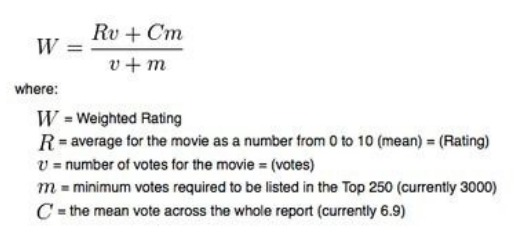

In [44]:
# Calculating the mean vote across the whole df
C = df_merged['Rating-Mean'].mean()


In [45]:
# Calculating the minimum votes required to be listed in the top 5%
m = rating_count.quantile(.95)[0]


/var/folders/4m/ykffh7vn0mjdcbcw9mrnzvt80000gn/T/ipykernel_52492/1265687929.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m = rating_count.quantile(.95)[0]


In [46]:
# IMDB formula; source: https://tutorialedge.net/python/building-imdb-top-250-clone-pandas/
def weighted_rating(x, m=m, C=C):
    v = x['Rating-Count']
    R = x['Rating-Mean']

    return (v/(v+m) * R) + (m/(m+v) * C)

## **Splitting the Dataset into Two Based on the Explicit and Implicit Ratings**

In [47]:
df_merged_updated=df_merged[df_merged['Book-Rating']!=0]

In [48]:
p(f" Implicit dataset has {df_merged.shape[0]-df_merged_updated.shape[0]} observations")
p(f" Explicit dataset has {df_merged_updated.shape[0]} observations")

 Implicit dataset has 576893 observations
 Explicit dataset has 340040 observations


In [49]:
# Create relevant sub-dataset
df_top_10 = df_merged_updated.copy().loc[df_merged_updated['Rating-Count'] >= m]
df_top_10.shape

(163365, 14)

In [50]:
df_top_10['Score'] = df_top_10.apply(weighted_rating, axis=1)

# **3. Exploratory Data Analysis**

##1. Ratings Count

### a) Explicit+Implicit Ratings

In [51]:
rating_count=df_ratings['Book-Rating'].value_counts().reset_index().sort_values('Book-Rating',ascending=False)

In [52]:
print(rating_count.columns)

Index(['Book-Rating', 'count'], dtype='object')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


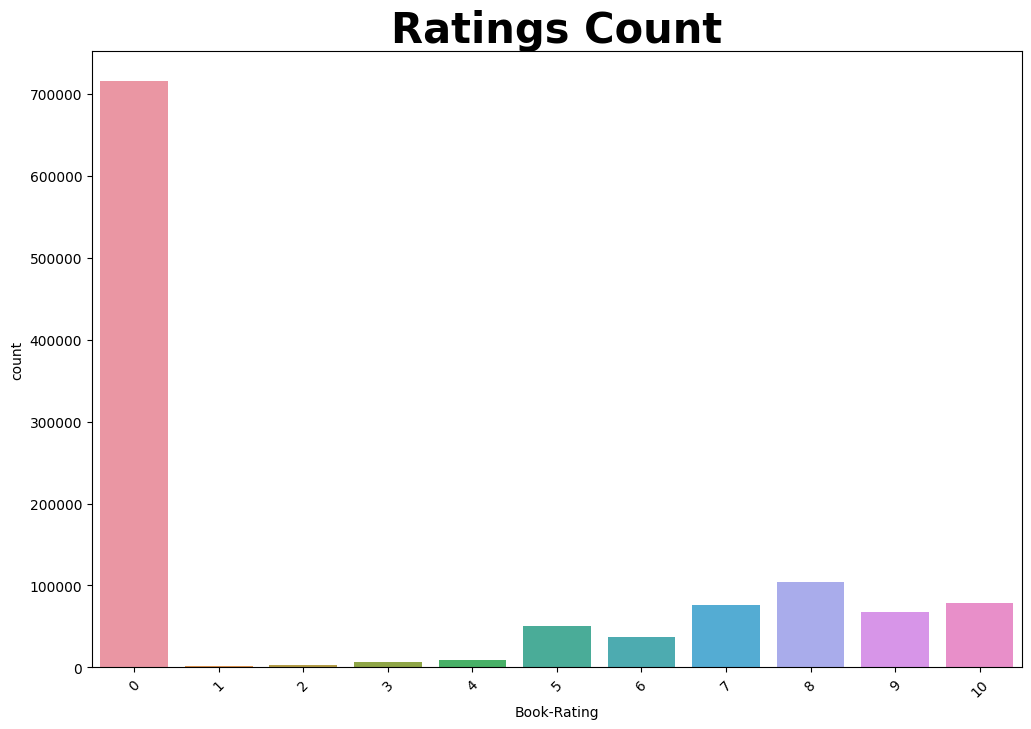

In [53]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x='Book-Rating', y='count', data=rating_count)
ax.set_title('Ratings Count', fontsize=30, fontweight='bold')
plt.xticks(rotation=45)  # Optional: rotate x-axis labels if needed for readability
plt.show()


### **Conclusion**: The datset with both explicit and implicit ratings is highly skewed toward the value of zero.

### b) Explicit Ratings

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


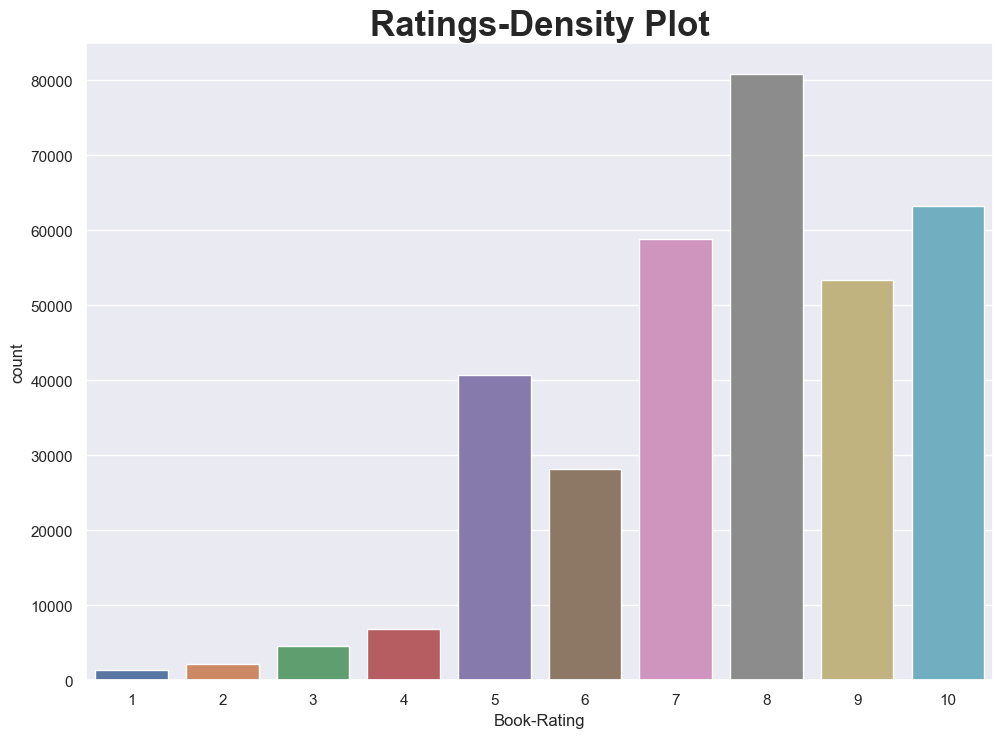

In [54]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
# df_merged_updated = df_merged_updated[df_merged['Book-Rating']!=0]
sns.countplot(x='Book-Rating', data=df_merged_updated).set_title('Ratings-Density Plot', weight='bold').set_fontsize('25')

### **Conclusion**: The skewness perishes after we remove the implicit ratings.

## 2. Author V/S Ratings

In [55]:
# ratings count per author
auth_rating=df_merged.groupby(['Book-Author'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

In [56]:
print(auth_rating.columns)

Index(['Book-Author', 'Book-Rating'], dtype='object')


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


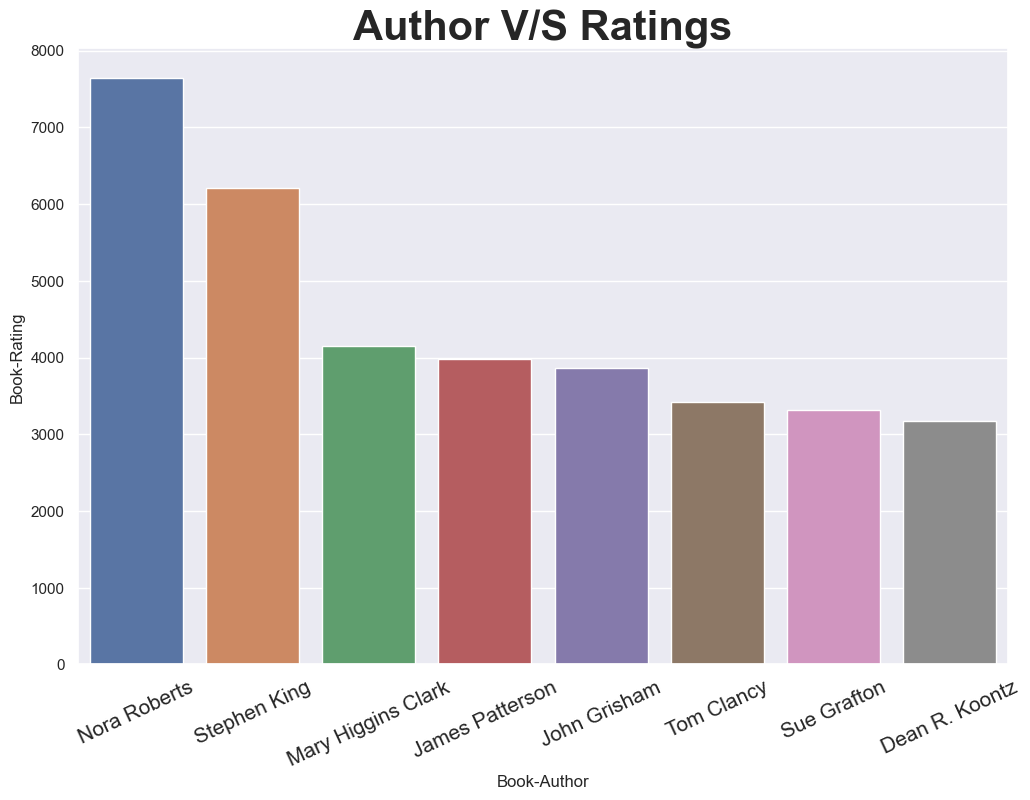

In [57]:
plt.figure(figsize=(12, 8))
# Filter the data first, then use x and y as arguments
filtered_data = auth_rating[auth_rating['Book-Rating'] > 3000]
ax = sns.barplot(x='Book-Author', y='Book-Rating', data=filtered_data)
ax.set_title('Author V/S Ratings', fontsize=30, fontweight='bold')
plt.xticks(fontsize=15, rotation=25)
plt.show()


*   ### Here, we can observe, most frequently rated Authors.
*   ### Most frequently rated author is Nora Roberts, followed by Stephen King.

## 3. Book Ratings Count

In [58]:
#Book ratings count using group by
book_rating=df_merged.groupby(['Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


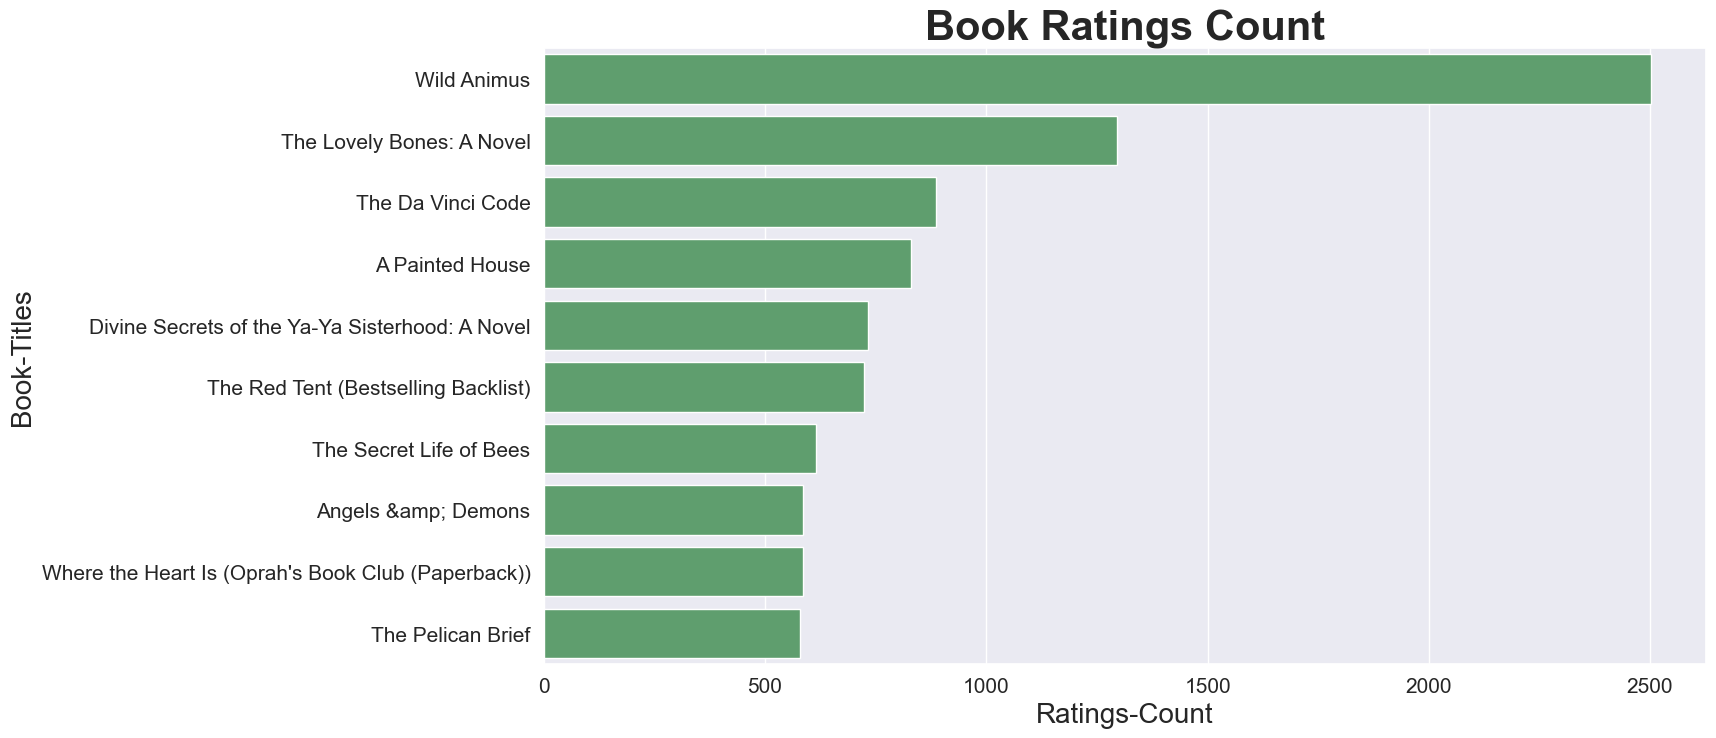

In [59]:
plt.figure(figsize=(15, 8))
# Use x and y as keyword arguments
ax = sns.barplot(x='Book-Rating', y='Book-Title', data=book_rating[:10], color='g')
ax.set_title('Book Ratings Count', fontsize=30, fontweight='bold')
ax.set_xlabel('Ratings-Count', fontsize=20)
ax.set_ylabel('Book-Titles', fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()





*   ### Here, we are able to observe, most frequently rated books by the users.
*   ### Most frequently rated book, happens to be Wild Animus.




## 4. Location

In [60]:
#Identifying what % of customers are coming from different countries
df_location = pd.DataFrame(df_location.country.value_counts(normalize=True)).reset_index()
df_location.columns = ['countries','value_counts']

#Labeling countries with low customer % as other
df_location['countries'] = df_location.apply(lambda x: 'other' if (x['value_counts'] < 0.01 or x['countries'] == '') else x['countries'],axis=1)

#Grouping the customer % from 'other' countries 
df_location = df_location.groupby('countries')['value_counts'].sum().reset_index()

In [61]:
#Every country has now just one occurance
df_location.countries.value_counts()

countries
 australia         1
 canada            1
 france            1
 germany           1
 italy             1
 netherlands       1
 new zealand       1
 portugal          1
 spain             1
 united kingdom    1
 usa               1
other              1
Name: count, dtype: int64

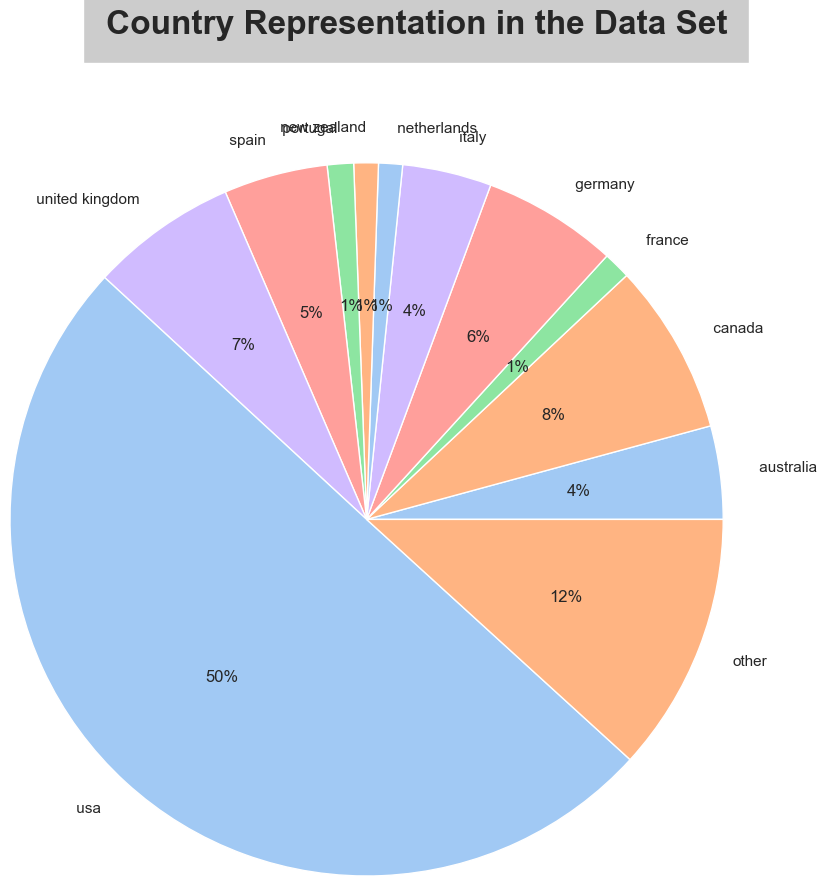

In [62]:
#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.title("Country Representation in the Data Set",bbox={'facecolor':'0.8', 'pad':8},fontsize=24, fontdict={"weight": "bold"},y=1.25,x=0.578)
f = plt.pie(df_location['value_counts'], labels = df_location['countries'], colors = colors, autopct='%.0f%%',radius=1.4)



*   ### Most customers are from United states of America, followd by Canada, United Kingdom and Germany.
*   ### Countries with less than 1% customers are labeled as other



## 4. Age vs Rating Density


<Axes: >

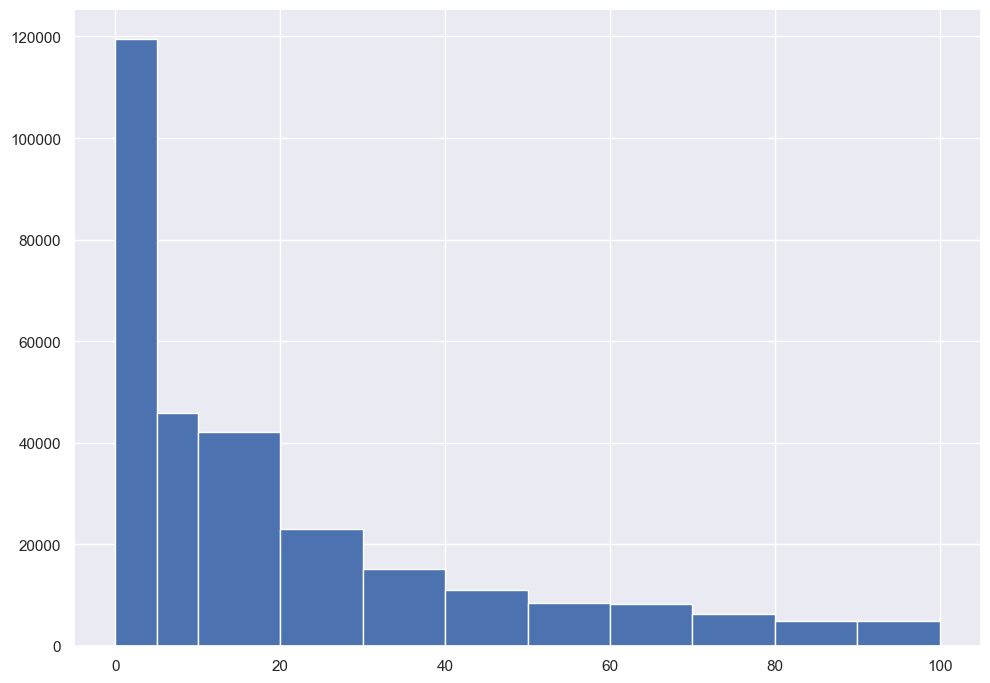

In [63]:
# Visualizing the rating counts of the users. 
df_merged_updated['Rating-Count'].hist(bins=[0,5,10,20,30,40,50,60,70,80,90,100])

<Axes: >

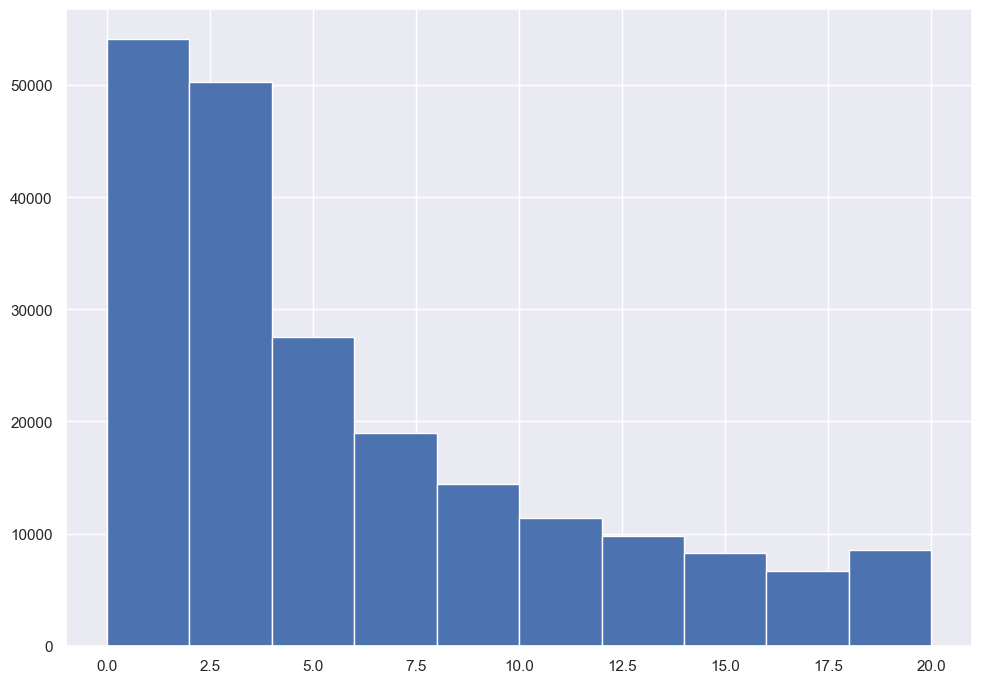

In [64]:
# Visualizing the rating counts of the users in the range between 0 to 20. 
df_merged_updated['Rating-Count'].hist(bins=[0,2,4,6,8,10,12,14,16,18,20])

## **From this visualization it is evident that most books have been rated by 2 to 5 users only.**

## 5. Age Bin Representation

/var/folders/4m/ykffh7vn0mjdcbcw9mrnzvt80000gn/T/ipykernel_52492/379647527.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_merged.groupby('age_bins')['Book-Rating'].count().plot(kind='pie')


<Axes: ylabel='Book-Rating'>

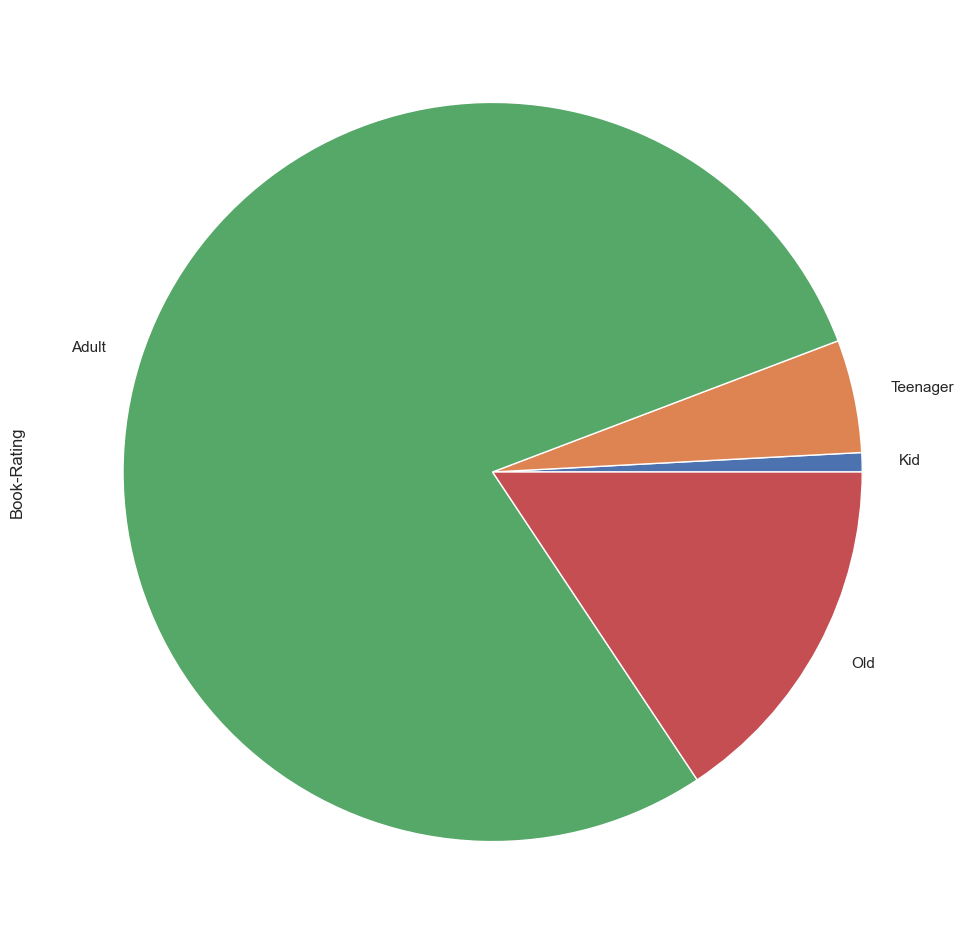

In [65]:
# Age group that rated books the most
plt.figure(figsize=(20,12))
df_merged.groupby('age_bins')['Book-Rating'].count().plot(kind='pie')

*   ### Most customers are Adults (20-50yrs).
* ### 2nd most represented age group is for boomers (>50yrs).



In [66]:
# Which country rates books the most
# Assuming the country is the last part after the last comma
df_merged['country'] = df_merged['Location'].apply(lambda x: x.split(',')[-1].strip())
b1 = df_merged.groupby('country')['Book-Rating'].count().sort_values(ascending=False).head(5)
b1

country
usa               660618
canada             82214
united kingdom     29795
germany            26024
                   21364
Name: Book-Rating, dtype: int64

In [67]:
print(df_merged.columns)


Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'new_title', 'Location', 'Age',
       'Title-Length', 'age_bins', 'Rating-Count', 'Rating-Mean', 'country'],
      dtype='object')


In [68]:
# Implicit ratings i.e. Book-Rating = 0
b2 = df_merged[df_merged['Book-Rating']==0].\
groupby('Location')['Book-Rating'].count().sort_values(ascending=False).head(5)

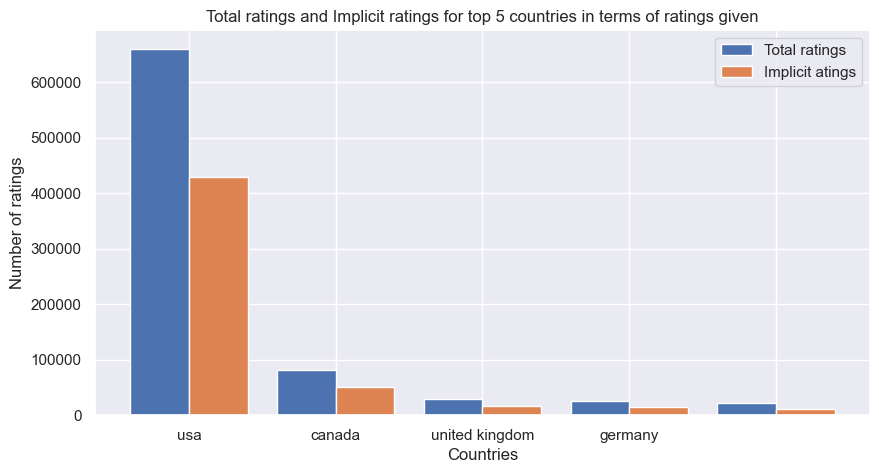

In [69]:
# Bar plot for Rating comparison 
n= 5
X_axis = np.arange(n)
X = b1.index

plt.figure(figsize=(10,5))  
plt.bar(X_axis - 0.2, b1, 0.4, label = 'Total ratings')
plt.bar(X_axis + 0.2, b2, 0.4, label = 'Implicit atings')
  
plt.xticks(X_axis, X)
plt.xlabel("Countries")
plt.ylabel("Number of ratings")
plt.title("Total ratings and Implicit ratings for top 5 countries in terms of ratings given")
plt.legend()
plt.show()

In [70]:
# Most popular books for different age groups
age_bin_df = df_merged.groupby(['age_bins','Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()
age_bin_df.rename(columns={'Book-Title':'Number of times rated'},inplace=True)

/var/folders/4m/ykffh7vn0mjdcbcw9mrnzvt80000gn/T/ipykernel_52492/226818608.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_bin_df = df_merged.groupby(['age_bins','Book-Title'])['Book-Rating'].count().sort_values(ascending=False).reset_index()


### **Note**: Users from each age category can be said to have some similar book preferences, we will later use Age as a relevance to recommend books for implicit ratings.

In [71]:
# Size of dataset rows before the User selection operation.
df_size_before_removing_Novice_readers = df_merged_updated.shape[0]
df_size_before_removing_Novice_readers

340040

In [72]:
# Storing the value counts of User-ID's in a new variable named counts1
counts1 = df_merged_updated['User-ID'].value_counts()

# Removing the User-ID's which have rated less than 10 books.
df_merged_updated= df_merged_updated[df_merged_updated['User-ID'].isin(counts1[counts1 >=10].index)].reset_index()
df_merged_updated.drop(columns='index', inplace=True)

In [73]:
df_merged_updated.shape

(227268, 14)

In [74]:
# Size of dataset rows after the User selection operation.
df_size_after_removing_Novice_readers = df_merged_updated.shape[0]
df_size_after_removing_Novice_readers

227268

In [75]:
df_merged_updated.shape

(227268, 14)

# **5. Building Models**

## **1. Recommendations Based upon Top 10 Books with the highest average rating (Explicit)**

In [76]:
# top 10 rated books based on the Rating-Mean colummn
top_rated = df_merged_updated[['Book-Title', 'Rating-Mean']]
top_rated = top_rated.groupby(['Book-Title'])['Rating-Mean'].mean().to_frame()
top_rated.sort_values(by='Rating-Mean', ascending=False).head(10)

,Rating-Mean
Book-Title,
The Fairies: Photographic Evidence of the Existence of Another World,10.0
The Boy Who Cried Abba: A Parable of Trust and Acceptance,10.0
The Boxcar Children Cookbook,10.0
The Murder Stone,10.0
Whales (Grades 1-4),10.0
The Murder Artist : A Thriller,10.0
Mountain Man: A Novel of Male and Female in the Early American West,10.0
The Boy,10.0
The Boy Captive of Old Deerfield,10.0


## **2. Interactive: Top 10 books for respective authors**

In [77]:
# Recommending Books Based Upon Authors:-
@interact
def recommend_books_based_upon_author( Book_Author = list(df_top_10['Book-Author'].value_counts().index)):
  a = df_top_10[df_top_10['Book-Author']==Book_Author][['Book-Title', 'Rating-Mean']]
  a = a.groupby(['Book-Title'])['Rating-Mean'].mean().to_frame()
  a = a.sort_values(by = 'Rating-Mean', ascending=False)
  return a.head(10)
#Load the drive to use the interactive feature

interactive(children=(Dropdown(description='Book_Author', options=('Nora Roberts', 'Stephen King', 'James Patt…

* ### By using the above drop down window, you can see the books from each publishing house that lie in the top 10 % based upon the Imdb criteria that was shown above.

## **3. Memory Based Knn Model**

In [78]:
df_Knn = df_merged_updated.copy(deep=True)

In [79]:
df_Knn['Score'] = df_merged_updated.apply(weighted_rating, axis=1)

In [80]:
#df_Knn.drop(columns=['Book-Title','Title-Lenght','age_bins'],inplace=True)

In [81]:
# Dropping the columns that aren't much useful for KNN recommendation system.
df_Knn.drop(columns=['ISBN',	'Book-Author',	'Year-Of-Publication',	'Publisher','Age','Location', 'Book-Rating', 'Rating-Count', 'Rating-Mean','Book-Title','Title-Length','age_bins'], inplace=True)

In [82]:
# Calculating the total number of books in the dataset and the number of books used in the recommendation system.

Number_of_books_in_dataset = len(df_books['Book-Title'].unique())
Number_of_books_considered_for_recommendation = len(df_Knn['new_title'].unique())

In [83]:
# Percentage of books considered for recommendation.

per_books_in_recommendation_system = (Number_of_books_considered_for_recommendation*100)/Number_of_books_in_dataset
per_books_in_recommendation_system

45.287546203564126

In [84]:
# Building the Final dataframe for the KNN Model.
df_final = pd.pivot_table(data=df_Knn, index='new_title', columns='User-ID', values='Score').fillna(0)

In [85]:
df_final.shape

(109657, 5860)

In [86]:
df_final.head(2)

User-ID,242,243,254,388,392,446,503,505,507,638,...,278202,278221,278314,278356,278418,278535,278582,278633,278843,278851
new_title,,,,,,,,,,,,,,,,,,,,,
"A Light in the Storm: The Civil War Diary of Amelia Martin, Fenwick Island, Delaware, 1861 (Dear America) by Karen Hesse",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Ask Lily (Young Women of Faith: Lily Series, Book 5) by Nancy N. Rue",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [87]:
# converting the sparse matrix into condensed matrix using scipy.sparse functionality.
df_matrix = csr_matrix(df_final.values)

In [88]:
# Building a KNN model with Cosine Similarity as the target metric for calculating the distances.
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute', n_neighbors=5)
model_knn.fit(df_final)

NearestNeighbors(algorithm='brute', metric='cosine')

In [89]:
# Building item to item recommendation model for the book readers
def recommend(movie, n_values=11):
  distances, indices = model_knn.kneighbors(df_final.loc[movie,:].values.reshape(1, -1), n_neighbors = n_values)
  for i in range(0, len(distances.flatten())):
    if i == 0:
        print(f'The Top {n_values - 1} Recommendations for Users who have read book {movie} are shown below:-')
    else:
        print('{0}: {1}, with distance of {2}.'.format(i, df_final.index[indices.flatten()[i]], distances.flatten()[i]))

In [96]:
recommend('9-11 by Noam Chomsky', n_values=10)

The Top 9 Recommendations for Users who have read book 9-11 by Noam Chomsky are shown below:-
1: Pop-Up: Animals Showing Off by Tony Chen, with distance of 0.6077677297236319.
2: Inseln der SÃ¼dsee: 7 Reisen ins Paradies by Hans Otto Meissner, with distance of 0.6077677297236319.
3: Presidential (Mis)Speak: The Very Curious Language of George W. Bush by Robert S. Brown, with distance of 0.6077677297236319.
4: My First Presidentiary : A Scrapbook by George W. Bush by Modern Humorist, with distance of 0.6077677297236319.
5: Pickup on Noon Street by Raymond Chandler, with distance of 0.6077677297236319.
6: Mein geheimes Leben. by Paul Theroux, with distance of 0.6077677297236319.
7: Mister King by Raija Siekkinen, with distance of 0.6077677297236319.
8: Fever Pitch. Ballfieber - Die Geschichte eines Fans. by Nick Hornby, with distance of 0.6077677297236319.
9: 2024: A Graphic Novel by Ted Rall, with distance of 0.6077677297236319.


In [101]:
import ipywidgets as widgets
from IPython.display import display

# Create a text widget for input
book_name_widget = widgets.Text(
    value='',
    placeholder='Type the name of the book',
    description='Book Name:',
    disabled=False
)

# Display the widget
display(book_name_widget)

# Define a function to capture and print the input when the text is changed
def on_book_name_change(change):
    print("Book name entered:", change['new'])

# Set up the observer



Text(value='', description='Book Name:', placeholder='Type the name of the book')

In [103]:
recommend(book_name_widget.value, n_values=10)

KeyError: 'Timeline'

* ### We can see, that the recommended books, are quite similar in genre to the selected item

## **4. Collaborative Filtering Model (Explicit)**

In [ ]:
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = df_merged_updated.groupby(['User-ID','Book-Title'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('# of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head(2)

# of unique user/item interactions: 227074


,User-ID,Book-Title,Book-Rating
0,242,Das Buch der lÃ?Â¤cherlichen Liebe.,3.000000
1,242,Das BÃ?Â¶se kommt auf leisen Sohlen.,3.321928


In [ ]:
le = preprocessing.LabelEncoder()
le.fit(interactions_full_df['Book-Title'].unique())

LabelEncoder()

In [ ]:

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df, 
                                   test_size=0.20,
                                   stratify=interactions_full_df['User-ID'],
                                   random_state=42)

print('# interactions on Train set: %d' % len(interactions_train_df))
print('# interactions on Test set: %d' % len(interactions_test_df))

# interactions on Train set: 181659
# interactions on Test set: 45415


In [ ]:
interactions_train_df['Book-Title'] = le.transform(interactions_train_df['Book-Title'])
interactions_test_df['Book-Title'] = le.transform(interactions_test_df['Book-Title'])

interactions_train_df.head()

,User-ID,Book-Title,Book-Rating
205710,248718,15905,3.169925
112413,128696,52086,3.459432
42886,46398,53622,2.584963
149990,177432,90831,3.169925
218410,265383,685,3.169925


In [ ]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='User-ID', 
                                                          columns='Book-Title', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head(2)

Book-Title,0,1,2,3,4,6,7,8,9,10,...,106832,106833,106835,106836,106837,106839,106840,106843,106844,106845
User-ID,,,,,,,,,,,,,,,,,,,,,
242,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
243,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[242, 243, 254, 388, 392, 446, 503, 505, 507, 638]

## **Singular Value Decomposition**

In [ ]:
from scipy.sparse.linalg import svds
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [ ]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 3.09110267e-05,  1.29188070e-05, -2.20344243e-04, ...,
        -3.52343841e-06,  4.94851990e-06,  1.44272699e-05],
       [ 4.24652072e-04,  1.26475978e-04, -6.54922868e-04, ...,
        -2.11284056e-05, -5.91071873e-06,  5.56560387e-05],
       [ 1.09376218e-03,  2.92057992e-04,  4.08915348e-04, ...,
        -6.43778626e-05, -2.72256821e-05,  9.67426562e-05],
       ...,
       [ 6.19905909e-04,  1.72495150e-04,  2.72850607e-04, ...,
        -4.75980637e-05,  3.31962875e-05,  8.39288286e-05],
       [ 2.86414181e-04,  8.29970018e-05, -8.28809129e-04, ...,
        -2.35480817e-05,  1.16909867e-05,  4.34523717e-05],
       [-1.05519719e-05,  5.91379865e-06, -9.90162199e-05, ...,
         1.00885231e-06, -1.12574659e-06,  1.06441294e-05]])

In [ ]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(2)

,242,243,254,388,392,446,503,505,507,638,...,278202,278221,278314,278356,278418,278535,278582,278633,278843,278851
Book-Title,,,,,,,,,,,,,,,,,,,,,
0,0.000031,0.000425,0.001094,0.000101,5.880726e-19,0.000028,0.000194,0.000134,0.000198,0.001062,...,0.000159,0.000123,0.000043,0.000060,0.000227,0.000242,0.000322,0.000620,0.000286,-0.000011
1,0.000013,0.000126,0.000292,0.000028,2.268762e-19,0.000013,0.000057,0.000035,0.000073,0.000302,...,0.000048,0.000030,0.000012,0.000021,0.000050,0.000077,0.000107,0.000172,0.000083,0.000006


In [ ]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['Book-Title'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'Book-Title', 
                                                          right_on = 'Book-Title')[['recStrength','Book-Title']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, items_df=df_merged_updated)

In [ ]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.set_index('User-ID')

In [ ]:
interactions_test_indexed_df.head()

,Book-Title,Book-Rating
User-ID,,
235105,9796,3.000000
128835,27840,3.459432
21031,73565,3.321928
60263,53033,3.459432
23872,58449,3.459432


In [ ]:
def get_items_interacted(person_id, interactions_df):
    interacted_items = interactions_df.loc[person_id]['Book-Title']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [ ]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(df_merged_updated['Book-Title'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(list(non_interacted_items), sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['Book-Title']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['Book-Title'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['Book-Title'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id%2)

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['Book-Title'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['Book-Title'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator() 

In [ ]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
5859 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.6373004513927116, 'recall@10': 0.6373004513927116}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
29,781,781,1227,0.636512,0.636512,11676
43,451,451,1064,0.423872,0.423872,98391
100,73,73,348,0.209770,0.209770,189835
167,178,178,347,0.512968,0.512968,153662
466,59,59,216,0.273148,0.273148,23902
465,55,55,191,0.287958,0.287958,76499
0,103,103,182,0.565934,0.565934,235105
148,87,87,176,0.494318,0.494318,171118
166,76,76,175,0.434286,0.434286,248718
40,114,114,170,0.670588,0.670588,16795


### We have obtained 
###● **Recall@5: 99%**
###● **Recall@10: 99%**

## Checking the output of Our Recommender

In [ ]:
recc = cf_recommender_model.recommend_items(40943)
recc = le.inverse_transform(recc['Book-Title'])
recc

array(['The Lovely Bones: A Novel', 'The Da Vinci Code',
       'The Red Tent (Bestselling Backlist)', 'The Secret Life of Bees',
       'Harry Potter and the Order of the Phoenix (Book 5)',
       'Good in Bed', 'Divine Secrets of the Ya-Ya Sisterhood: A Novel',
       "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))",
       'To Kill a Mockingbird', 'A Time to Kill'], dtype=object)

In [ ]:
df_merged_updated[df_merged_updated['User-ID']==40943].head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Length,age_bins,Rating-Count,Rating-Mean
3121,40943,0385730586,10,Sisterhood of the Traveling Pants,ANN BRASHARES,2003,Delacorte Books for Young Readers,Sisterhood of the Traveling Pants by ANN BRASH...,usa,40,33,Adult,130,3.87
3442,40943,0061020710,9,The Color of Magic,Terry Pratchett,2000,HarperTorch,The Color of Magic by Terry Pratchett,usa,40,18,Adult,103,3.19
3647,40943,0312288115,1,Confessions of a Sociopathic Social Climber : ...,Adele Lang,2002,Thomas Dunne Books,Confessions of a Sociopathic Social Climber : ...,usa,40,119,Adult,66,1.59
6996,40943,0743418174,10,Good in Bed,Jennifer Weiner,2002,Washington Square Press,Good in Bed by Jennifer Weiner,usa,40,11,Adult,470,4.04
10282,40943,039480967X,5,Bears on Wheels (Bright &amp; Early Books),STAN BERENSTAIN,1969,Random House Books for Young Readers,Bears on Wheels (Bright &amp; Early Books) by ...,usa,40,42,Adult,13,4.08


* ## We can see, the user: **40943**, has rated **Sisterhood of the Traveling Pants**, very highly. Our model, is recommending other parts of the same series. This seems to be consistent with high precision and high recall values that we have obtained thus far.

## **5. Recommendations for implicit case With KNN Based Model**


* #### Implicit ratings are those ratings in our dataset wherein the users have not directly expressed their ratings for purchased books.

*  #### 2. In that case we can not know the exact preferences of a user regarding these books.

*  #### 3. For such users we have decided to build a recommendation system using the criteria of Age as relevance for the recommendations.

In [ ]:
# Filter out the explicitly rated books
implicit_ratings_df = df_merged[df_merged['Book-Rating']==0]
implicit_ratings_df.shape

(576893, 15)

In [ ]:
# Check its shape
implicit_ratings_df.shape

(576893, 15)

In [ ]:
# Create an interactions dataframe 
implicit_ratings_interactions_df = implicit_ratings_df[['User-ID','ISBN','Age']]
implicit_ratings_interactions_df.head()

,User-ID,ISBN,Age
0,276725,034545104X,25
2,6543,034545104X,34
5,23768,034545104X,45
6,28266,034545104X,40
7,28523,034545104X,24


In [ ]:
p(implicit_ratings_interactions_df.shape)

(576893, 3)


In [ ]:
# Filter out books rated less than 50 times
y = implicit_ratings_interactions_df['ISBN'].value_counts()>50
y[y].sum()

875

In [ ]:
# Index of books rated more than 50 times
index_books= y[y].index

In [ ]:
# Select books rated more than 50 times
select_implicit_df = implicit_ratings_interactions_df[implicit_ratings_interactions_df['ISBN'].isin(index_books)]
select_implicit_df.shape

(83206, 3)

In [ ]:
# Filter out users who have given less than 10 ratings
x = select_implicit_df['User-ID'].value_counts()>50
x[x].sum()

267

In [ ]:
# Index of selected users
index_users = x[x].index

In [ ]:
# Selected users 
select_implicit_df = select_implicit_df[select_implicit_df['User-ID'].isin(index_users)]
select_implicit_df.shape

(26189, 3)

In [ ]:
select_implicit_df.head()

,User-ID,ISBN,Age
116,11676,0060173289,39
117,87746,0060173289,52
118,113519,0060173289,33
120,159033,0060173289,46
123,51883,0060173289,31


In [ ]:
#Creating a sparse pivot table with users in rows and items in columns and age as values
users_ages_pivot_matrix_df = select_implicit_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Age').fillna(0)
# Transpose to get user_ids as columns
pivot_df = users_ages_pivot_matrix_df.transpose()
pivot_df.head()

User-ID,3363,6251,6575,7158,7346,11601,11676,12538,13273,13552,...,268032,268330,269566,269719,271284,273979,274308,275970,277427,278418
ISBN,,,,,,,,,,,,,,,,,,,,,
002026478X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,33.0,0.0,0.0,0.0,0.0,0.0,0.0
002542730X,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0060096195,29.0,0.0,0.0,0.0,0.0,0.0,35.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
006016848X,0.0,0.0,0.0,0.0,49.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0
0060173289,0.0,0.0,24.0,0.0,0.0,0.0,39.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Import csr_matrix and apply on the pivot obtained
sparse_matrix = csr_matrix(pivot_df)

In [ ]:
# Import NearestNeighbors from sklearn
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [ ]:
# Fit the sparse matrix to the model
knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
# Define a fuction to obtain recommendations
def get_recommendations(user_id,num_of_recommendations):
  distances,suggestions = knn.kneighbors(pivot_df.iloc[user_id,:].values.reshape(1,-1),n_neighbors=num_of_recommendations)
  for i in range(len(suggestions)):
    recom_array = pivot_df.index[suggestions[i]]
    movie_set = set(df_merged[df_merged['ISBN'].isin(recom_array)]['Book-Title'])
  return movie_set


In [ ]:
# Get recommendations for users based on user-ids
get_recommendations(508,10)

{'A Painted House',
 'Cat &amp; Mouse (Alex Cross Novels)',
 'False Memory',
 'Irish Hearts',
 'Night Prey',
 "Songs in Ordinary Time (Oprah's Book Club (Paperback))",
 'Stone Kiss',
 'The Beach House',
 'The Brethren',
 'We Were the Mulvaneys'}

In [ ]:
# Obtain Neighbours for the above user
knn.kneighbors(pivot_df.iloc[508,:].values.reshape(1,-1))

(array([[0.        , 0.54950258, 0.5735198 , 0.57931588, 0.5798158 ,
         0.58303291, 0.58347435, 0.58439061, 0.58752838, 0.58773569,
         0.59095861, 0.59211594, 0.59771244, 0.60781641, 0.60915601,
         0.61321479, 0.61374917, 0.61654817, 0.62237982, 0.62356667]]),
 array([[508, 505, 332,  58, 569, 202, 437, 441, 489, 677, 444, 590, 404,
          38, 110, 331, 144, 693, 663, 636]]))

In [ ]:
# Check recommendations for Neighbours
get_recommendations(505,10)

{'A Walk to Remember',
 'After All These Years',
 'Black and Blue',
 'Dance upon the Air (Three Sisters Island Trilogy)',
 'Dust to Dust',
 'Night Prey',
 'Stone Kiss',
 'The Beach House',
 'The Notebook',
 'The Rosewood Casket'}

In [ ]:
get_recommendations(677,10)

{'A Painted House',
 'False Memory',
 'Sea Glass: A Novel',
 'Shopaholic Takes Manhattan (Summer Display Opportunity)',
 "Songs in Ordinary Time (Oprah's Book Club (Paperback))",
 'Still Waters',
 'Stone Kiss',
 'The Beach House',
 'The Notebook',
 'While I Was Gone'}

In [ ]:
# Common book recommendations between neighbours i.e users of similar age group
get_recommendations(508,10).intersection(get_recommendations(677,10))

{'A Painted House',
 'False Memory',
 "Songs in Ordinary Time (Oprah's Book Club (Paperback))",
 'Stone Kiss',
 'The Beach House'}

* ### We can clearly see that the recommender system is recommending quite similar books to users who are of similar age, hence our system seems to be working quite fine!

## **6. Content Description Based Recommender system**

### a) Extracting Summary from Google Books API

In [ ]:
# Python's built-in module for encoding and decoding JSON data
import json
# Python's built-in module for opening and reading URLs
from urllib.request import urlopen

api = "https://www.googleapis.com/books/v1/volumes?q=isbn:"

In [ ]:
gg = df_merged.drop_duplicates('Book-Title',keep='first')

In [ ]:
list_isbn = list(gg['ISBN'][gg['Book-Rating']==0].unique())

In [ ]:
list_dict= {}

* ### Google Books API has **restrictions** of number of requests. By using the following code, we have been able to circumvent those restrictions.

## ***The Below Given Code Was Once Used to Create a SCV File, With Book Descriptions***

In [ ]:
########## THE CODE WAS USED ONCE TO CREATE CSV FILE, WITH BOOK DESCRIPTIONS ##########


# def descripter(x):
#   global counter
#   counter +=1 
#   try:
#     return json.load(urlopen(api + x))['items'][0]['volumeInfo']["description"]
#   except:
#     print('No-Description')

# import time
# j = 52620
# while j!=len(list_isbn):

#   for i in list_isbn[j:j+80]:
#     list_dict[i] = descripter(i)
  
#   time.sleep(20)

#   j +=80  



###Exporting as CSV
# export_df = pd.DataFrame(list_dict.items(),columns=['ISBN','description'])
# export_df = export_df[~export_df['description'].isna()]

# from google.colab import files
# export_df.to_csv('description_df_1.csv')
# files.download('description_df_1.csv')


########## THE CODE WAS USED ONCE TO CREATE CSV FILE, WITH BOOK DESCRIPTIONS ##########

In [ ]:
df_descriptions = pd.read_csv('/content/drive/MyDrive/Alma Better/Capstone Project/description_df_1.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Alma Better/Capstone Project/description_df_1.csv'

In [ ]:
df_descriptions.head()

,Unnamed: 0,ISBN,description
0,0,034545104X,Twenty years after having an affair with legen...
1,1,0449912558,The sole survivor of a crew sent to explore a ...
2,2,0300069049,Franz Liszt's daughter Cosima began her diarie...
3,3,0375706771,"In the winter of 1981, trapped by unpassable r..."
4,4,0451525078,Cervantes' tale of the deranged gentleman who ...


In [ ]:
df_descriptions.drop('Unnamed: 0',axis=1,inplace=True)
df_tf = df_merged[df_merged['Book-Rating']==0]
df_tf = df_tf.merge(df_descriptions,how='inner',on='ISBN')
df_tf[df_tf['Book-Rating']==0].head(2)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Length,age_bins,Rating-Count,Rating-Mean,description
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,24,20,NaN,60,2.93,Twenty years after having an affair with legen...
1,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,Flesh Tones: A Novel by M. J. Rose,usa,34,20,Adult,60,2.93,Twenty years after having an affair with legen...


### b) Data Pre-processing

In [ ]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
stopwords.words('english').extend(['\n','\t'])

In [ ]:
#Removing Stop Words and Punctuations
def text_process(msg):
    nopunc =[char for char in msg if char not in string.punctuation]
    nopunc=''.join(nopunc)
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [ ]:
#Removing Stopwords
df_descriptions['description'] = df_descriptions['description'].apply(text_process)

In [ ]:
df_descriptions.head()

,ISBN,description
0,034545104X,Twenty years affair legendary artist George Ga...
1,0449912558,sole survivor crew sent explore new planet Jes...
2,0300069049,Franz Liszts daughter Cosima began diaries Jan...
3,0375706771,winter 1981 trapped unpassable roads midwife S...
4,0451525078,Cervantes tale deranged gentleman turns knight...


In [ ]:
nltk.download('wordnet')
# Create WordNetLemmatizer object
wnl = WordNetLemmatizer()

def lemma(text):    
    '''a function which stems each word in the given text'''
    text = [wnl.lemmatize(word) for word in text.split()]
    return " ".join(text)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
df_descriptions['description'] = df_descriptions['description'].apply(lemma)

### c) Vectorizing The Data

In [ ]:
tfidf = TfidfVectorizer(min_df=5)
tfidf_mat = tfidf.fit_transform(df_descriptions['description'])

In [ ]:
# Change chunk_size to control resource consumption and speed
# Higher chunk_size means more memory/RAM needed but also faster 
chunk_size = 500 
matrix_len = tfidf_mat.shape[0] # Not sparse numpy.ndarray

def similarity_cosine_by_chunk(start, end):
    if end > matrix_len:
        end = matrix_len
    return cosine_similarity(X=tfidf_mat[start:end], Y=tfidf_mat) # scikit-learn function

for chunk_start in range(0, matrix_len, chunk_size):
    cosine_similarity_chunk = similarity_cosine_by_chunk(chunk_start, chunk_start+chunk_size)
    # Handle cosine_similarity_chunk  ( Write it to file_timestamp and close the file )
    # Do not open the same file again or you may end up with out of memory after few chunks 

In [ ]:
cosine_similarity_chunk = cosine_similarity_chunk.transpose()
indices = pd.Series(df_descriptions['ISBN'])

In [ ]:
def recommendations(ISBN,cosine_sim = cosine_similarity_chunk ):
  try:
    index = indices[indices == ISBN].index[0]
    similarity_scores = pd.Series(cosine_similarity_chunk[index]).sort_values(ascending=False)
    top_10_books = list(similarity_scores.iloc[1:11].index)
    recommended_books_ISBN = [df_tf[df_tf['ISBN']==df_descriptions.iloc[list(df_descriptions.index)[i]]['ISBN']]['Book-Title'].to_list()[0] for i in top_10_books]
    return recommended_books_ISBN

  except:
    print('The Book Is not Indexed')

In [ ]:
df_tf[df_tf['Book-Title']=="Miss Julia Takes over"].head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,new_title,Location,Age,Title-Length,age_bins,Rating-Count,Rating-Mean,description
7157,6543,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,34,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7158,64436,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,36,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7159,52584,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,45,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7160,164027,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,canada,33,21,NaN,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."
7161,269719,0142000892,0,Miss Julia Takes over,Ann B. Ross,2002,Penguin Books,Miss Julia Takes over by Ann B. Ross,usa,33,21,Adult,37,3.08,"Hazel Marie Puckett and her 19-year-old son, L..."


* ## For a user, say **User-ID: 6543** who has bought **Miss Julia Takes over)** and has left no rating, based on the content of this book, we can recommend the following titles.

In [ ]:
#Recommendations based on -> 0425144690: Died in the Wool
recommendations('0425144690')   

['The Burning City',
 'Budding prospects: A pastoral (Contemporary American fiction)',
 'Barrel Fever : Stories and Essays (Barrel Fever)',
 'The Nanny Diaries: A Novel',
 'With Thanks and Appreciation: The Sweet Nellie Book of Thoughts, Sentiments, Tokens and Traditions of the Past',
 'The Murder Book',
 'The Doubtful Guest',
 "The Samurai's Wife (A Sano Ichiro Mystery)",
 'The Best American Short Stories 2001',
 'Oracles and Miracles']

In [ ]:
#Recommendations based on ->0142000892: Miss Julia Takes over
recommendations('0142000892') 

['The Burning City',
 'Amy and Isabelle : A novel',
 'The River Midnight',
 'Mirror Mirror: A Novel',
 "Molly Moon's Incredible Book of Hypnotism (Molly Moon Books (Hardcvoer))",
 'The Big Bounce',
 "The Samurai's Wife (A Sano Ichiro Mystery)",
 'Died in the Wool',
 'Cyrano De Bergerac (Bantam Classics)',
 'Lost in a Good Book: A Thursday Next Novel']

In [ ]:
#Similar Recommendations:
[i for i in recommendations('0142000892')  if i in recommendations('0425144690')]

['The Burning City', "The Samurai's Wife (A Sano Ichiro Mystery)"]

* ### We can notice that, Books recommneded for a user who has previously read **Miss Julia Takes over**, have respective recommendations which are similar to each other. Thus, the content similary based recommendation system is working as, expected.

